In [1]:
import torch

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Build dataloader


In [13]:
test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

print(f"Length of training dataset: {len(train_data)}")
print(f"Length of test dataset: {len(test_data)}")

Length of training dataset: 60000
Length of test dataset: 10000


In [14]:
batch_size = 64

In [15]:
training_dataloader = DataLoader(train_data, batch_size = batch_size)

In [16]:
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [17]:
from torch import nn 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
device 

device(type='cpu')

In [21]:
for X, y in training_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}") 
    break

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [31]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [32]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [33]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader, model, nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=1e-3))
    test(test_dataloader, model, nn.CrossEntropyLoss())
print("Done!")

Epoch 1
-------------------------------
loss: 2.304575  [    0/60000]
loss: 2.297068  [ 6400/60000]
loss: 2.275356  [12800/60000]
loss: 2.265537  [19200/60000]
loss: 2.261594  [25600/60000]
loss: 2.215309  [32000/60000]
loss: 2.225691  [38400/60000]
loss: 2.186926  [44800/60000]
loss: 2.181589  [51200/60000]
loss: 2.159656  [57600/60000]
Test Error: 
 Accuracy: 40.8%, Avg loss: 2.152600 

Epoch 2
-------------------------------
loss: 2.158739  [    0/60000]
loss: 2.150429  [ 6400/60000]
loss: 2.093770  [12800/60000]
loss: 2.113181  [19200/60000]
loss: 2.069064  [25600/60000]
loss: 1.998192  [32000/60000]
loss: 2.025031  [38400/60000]
loss: 1.945670  [44800/60000]
loss: 1.942691  [51200/60000]
loss: 1.883735  [57600/60000]
Test Error: 
 Accuracy: 58.9%, Avg loss: 1.880109 

Epoch 3
-------------------------------
loss: 1.903100  [    0/60000]
loss: 1.874129  [ 6400/60000]
loss: 1.763132  [12800/60000]
loss: 1.811239  [19200/60000]
loss: 1.707573  [25600/60000]
loss: 1.654625  [32000/600

In [34]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [35]:
ls

MNIST_pytorch.ipynb  data/                model.pth


In [37]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))
print("Loaded PyTorch Model State from model.pth")

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: {predicted}, Actual: {actual}")

Loaded PyTorch Model State from model.pth
Predicted: Ankle boot, Actual: Ankle boot


In [38]:
import torch
print(torch.__version__)

import numpy as np
print(np.__version__)

2.2.2
1.26.4


In [41]:
data = torch.randint(0, 10, (3, 4))
print("Data:", data)
print("Shape of data:", data.shape)
print("Datatype of data:", data.dtype)

Data: tensor([[5, 0, 9, 7],
        [2, 7, 8, 3],
        [6, 0, 5, 1]])
Shape of data: torch.Size([3, 4])
Datatype of data: torch.int64


In [42]:

x_data = torch.tensor(data)

/var/folders/z8/2xm2q4mj5cn0lbtk9r82bh700000gn/T/ipykernel_55788/1366238538.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data = torch.tensor(data)


In [43]:
type(x_data)

torch.Tensor

In [47]:
np_array = np.array(data)
type(np_array)

numpy.ndarray

In [48]:
x_np = torch.from_numpy(np_array)

type(x_np)

torch.Tensor

In [50]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Accelerator found: MPS (Apple Silicon GPU)")


device

Accelerator found: MPS (Apple Silicon GPU)


device(type='mps')

In [51]:
import matplotlib.pyplot as plt

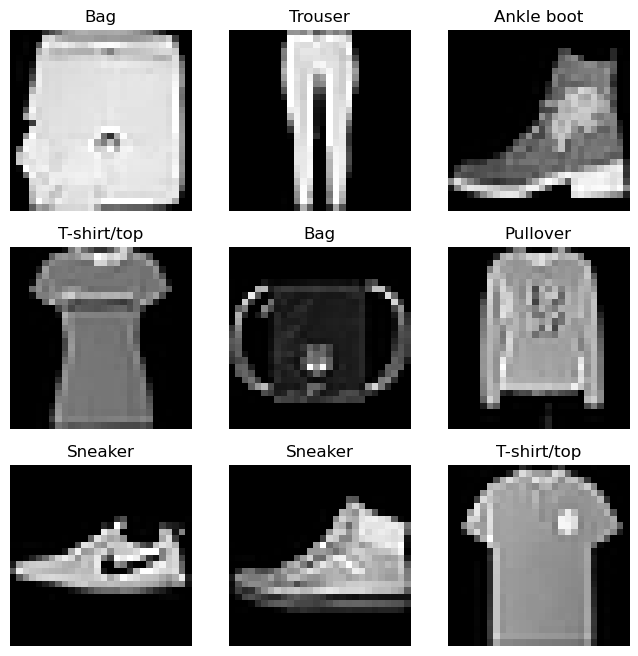

In [53]:
lebel_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(lebel_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()